In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as smp
from matplotlib import animation
from matplotlib.animation import PillowWriter

In [2]:
m1, m2, k, l0, R, g, t = smp.symbols('m_1 m_2 k l_0 R g t')
theta, l = smp.symbols('theta l', cls = smp.Function)

theta = theta(t)
l = l(t)

dtheta = smp.diff(theta ,t)
ddtheta = smp.diff(dtheta, t)

dl = smp.diff(l, t)
ddl = smp.diff(dl, t)

x1 = l*smp.sin(theta)
y1 = l*smp.cos(theta)

x2 = R*smp.sin(theta)
y2 = R*smp.cos(theta)

# t, g, m, h, w, A, l0, k = smp.symbols('t g m h w A l_0 k')
# x, ys = smp.symbols('x y_s', cls=smp.Function)
# ys = smp.sin(w*t)

# x = x(t)

# d_x = smp.diff(x, t)
# dd_x = smp.diff(d_x, t)

# x1 = x
# y1 = A*x**2

In [3]:
# T = smp.Rational(1,2)*m1*dl**2 + smp.Rational(1,2)*m2*(dl**2 + l**2*dtheta**2)
# U = -m2*g*R*smp.cos(theta)-m1*g*l*smp.cos(theta)+smp.Rational(1,2)*k*(R-l-l0)**2

T = smp.Rational(1,2)*m1*(smp.diff(x1,t)**2 + smp.diff(y1,t)**2) + smp.Rational(1,2)*m2*(smp.diff(x2,t)**2 + smp.diff(y2,t)**2)
U = -m1*g*y1 - m2*g*y2 + smp.Rational(1,2)*k*(R-l-l0)**2
U
T

# T = smp.Rational(1,2)*m*(smp.diff(x1, t)**2 + smp.diff(y1, t)**2)
# U = m*g*A*x**2 + smp.Rational(1,2)*k*(smp.sqrt((x**2+(h+ys-A*x**2)**2))-l0)**2

m_1*((-l(t)*sin(theta(t))*Derivative(theta(t), t) + cos(theta(t))*Derivative(l(t), t))**2 + (l(t)*cos(theta(t))*Derivative(theta(t), t) + sin(theta(t))*Derivative(l(t), t))**2)/2 + m_2*(R**2*sin(theta(t))**2*Derivative(theta(t), t)**2 + R**2*cos(theta(t))**2*Derivative(theta(t), t)**2)/2

In [4]:
L = T-U

In [5]:
L

R*g*m_2*cos(theta(t)) + g*m_1*l(t)*cos(theta(t)) - k*(R - l_0 - l(t))**2/2 + m_1*((-l(t)*sin(theta(t))*Derivative(theta(t), t) + cos(theta(t))*Derivative(l(t), t))**2 + (l(t)*cos(theta(t))*Derivative(theta(t), t) + sin(theta(t))*Derivative(l(t), t))**2)/2 + m_2*(R**2*sin(theta(t))**2*Derivative(theta(t), t)**2 + R**2*cos(theta(t))**2*Derivative(theta(t), t)**2)/2

In [6]:
EL1 = smp.diff(L,l) - smp.diff(smp.diff(L,dl),t).simplify()
EL2 = smp.diff(L,theta) - smp.diff(smp.diff(L, dtheta), t).simplify()

In [7]:
EL1

g*m_1*cos(theta(t)) - k*(-2*R + 2*l_0 + 2*l(t))/2 + m_1*(-2*(-l(t)*sin(theta(t))*Derivative(theta(t), t) + cos(theta(t))*Derivative(l(t), t))*sin(theta(t))*Derivative(theta(t), t) + 2*(l(t)*cos(theta(t))*Derivative(theta(t), t) + sin(theta(t))*Derivative(l(t), t))*cos(theta(t))*Derivative(theta(t), t))/2 - m_1*Derivative(l(t), (t, 2))

In [8]:
sol = smp.solve([EL1, EL2], (ddl, ddtheta), simplify = False, rational = False)
# now we have ddtheta = ... and ddl = ... explicitly

sol[ddtheta]


-R*g*m_2*sin(theta(t))/(R**2*m_2 + m_1*l(t)**2) - g*m_1*l(t)*sin(theta(t))/(R**2*m_2 + m_1*l(t)**2) - 2*m_1*l(t)*Derivative(l(t), t)*Derivative(theta(t), t)/(R**2*m_2 + m_1*l(t)**2)

In [9]:
dz1dt_f = smp.lambdify((m1, k, l0, R, g, t, l, theta, dtheta), sol[ddl]) # actually no dl dependence no m2 dependence...
dz2dt_f = smp.lambdify((m1, m2, R, g, t, l, theta, dl, dtheta), sol[ddtheta]) # actually no k dependence or l0...
dldt_f = smp.lambdify(dl, dl)
dthetadt_f = smp.lambdify(dtheta, dtheta)

In [10]:
def dSdt(S, t, m1, m2, k, l0, R, g):
  l, z1, theta, z2 = S
  return [
          dldt_f(z1),
          dz1dt_f(m1, k, l0, R, g, t, l, theta, z2),
          dthetadt_f(z2),
          dz2dt_f(m1, m2, R, g, t, l, theta, z1, z2)
  ]


In [16]:
t = np.linspace(0, 40, 1001)
m1 = 60
m2 = 3
k = 800
l0 = 1.5
R = 3
g = 9.8

ans = odeint(dSdt, y0=[2, 0, 0.1, 0], t=t, args=(m1, m2, k, l0, R, g))

In [17]:
l = ans.T[0]
theta = ans.T[2]
# print(l)
# print(theta)

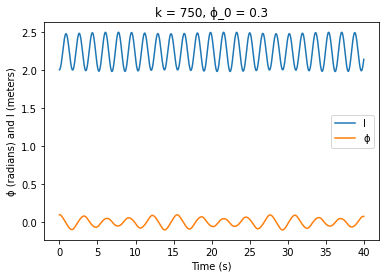

In [18]:
plt.plot(t,l)
plt.plot(t,theta)
plt.title('k = 750, ϕ_0 = 0.3')
plt.xlabel('Time (s)')
plt.ylabel('ϕ (radians) and l (meters)')
plt.legend(['l', 'ϕ'])

In [19]:
def get_position(t, R, l, theta):
  return (l*np.sin(theta), l*np.cos(theta), R*np.sin(theta), R*np.cos(theta))

x1, y1, x2, y2 = get_position(t, R, l, theta)

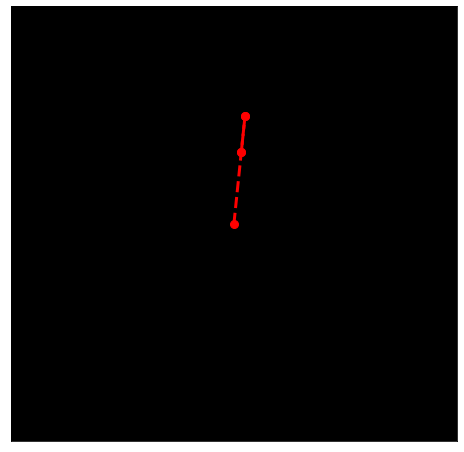

In [20]:
def animate(i):
  ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
  ln2.set_data([x1[i], x2[i]], [y1[i], y2[i]])


fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ln2, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-6,6)
ax.set_xlim(-6,6)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('1_small_oscillations.gif', writer='pillow', fps=25)